Imagem Polarização X carregada com sucesso.
Imagem Polarização Y carregada com sucesso.

Processando polarização X...
Processando polarização Y...

--- Resultados Finais para Polarização X ---
Coeficiente de Pearson (rho): 0.9641750653260325
Eficiência de Difração (DE): 1.0
RMSE de Uniformidade: 0.7370483412780097
Figure of Merit (FoM): 0.7370483412780097

--- Resultados Finais para Polarização Y ---
Coeficiente de Pearson (rho): 0.864750365636612
Eficiência de Difração (DE): 1.0
RMSE de Uniformidade: 0.32795335171516965
Figure of Merit (FoM): 0.32795335171516965


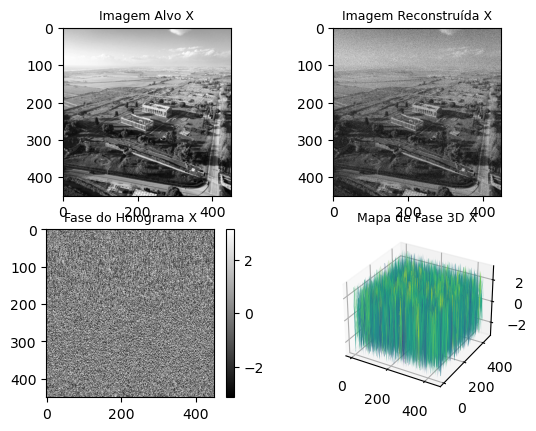

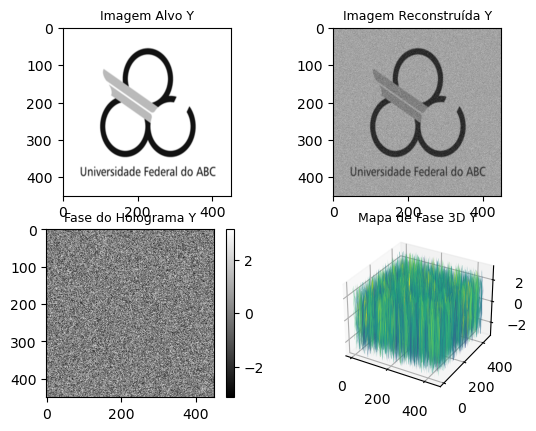

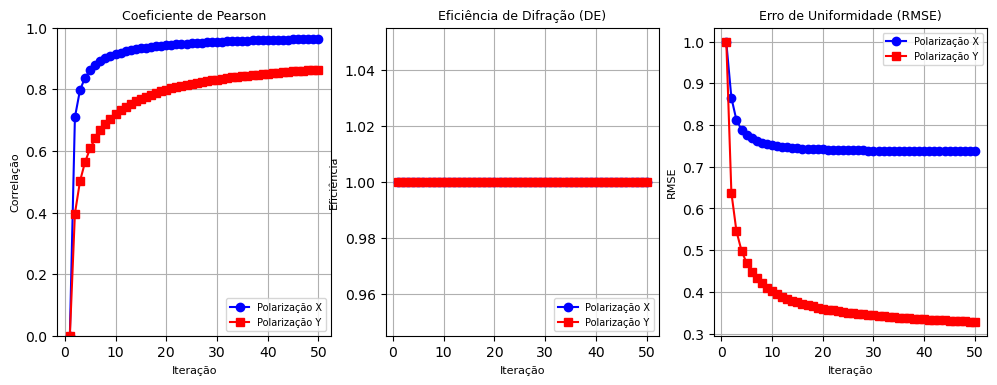


Simulação concluída.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, img_as_float
import sys

# ------------------------------
# Parâmetros da Simulação
# ------------------------------
lambda_ = 1064e-9       # Comprimento de onda em metros (1064 nm)
z = 380e-6              # Distância de propagação em metros (380 µm)
pixel_pitch = 520e-9    # Tamanho do pixel em metros (520 nm)

# Parâmetros do Algoritmo
N = 450                 # Número de pixels da metasuperfície (450x450)
max_iter = 50           # Número máximo de iterações para o algoritmo GS
L = N * pixel_pitch     # Tamanho físico da metasuperfície

# ------------------------------
# Carregar Imagens Alvo
# ------------------------------
try:
    target_img_x_rgb = io.imread("img1.jpg")
    print("Imagem Polarização X carregada com sucesso.")
    target_img_x = color.rgb2gray(img_as_float(target_img_x_rgb))

    target_img_y_rgb = io.imread("ufabc.jpg")
    print("Imagem Polarização Y carregada com sucesso.")
    target_img_y = color.rgb2gray(img_as_float(target_img_y_rgb))

except Exception as e:
    print("ERRO: Falha ao carregar ou processar as imagens.", e)
    sys.exit()

# ------------------------------
# Redimensionar e Normalizar Imagens
# ------------------------------
target_img_x = transform.resize(target_img_x, (N, N), anti_aliasing=True)
target_img_y = transform.resize(target_img_y, (N, N), anti_aliasing=True)

target_amplitude_x = target_img_x / np.max(target_img_x)
target_amplitude_y = target_img_y / np.max(target_img_y)

# ------------------------------
# Função de Cálculos Estatísticos
# ------------------------------
def calculate_stats(T, R):
    R_norm = R / np.max(R)
    T_flat = T.flatten()
    R_flat = R_norm.flatten()

    rho = np.corrcoef(T_flat, R_flat)[0, 1]

    I = R_norm**2
    I_flat = I.flatten()

    DE = np.sum(I_flat[T_flat > 0]) / np.sum(I_flat)

    I_target_region = I_flat[T_flat > 0]
    M_target = I_target_region.size
    mean_I_target = np.mean(I_target_region) if M_target > 0 else 0

    if mean_I_target > 0:
        RMSE = np.sqrt(np.sum((I_target_region - mean_I_target) ** 2) / M_target) / mean_I_target
    else:
        RMSE = 0

    FoM = (1 - DE) + RMSE
    return rho, DE, RMSE, FoM

# ------------------------------
# GS + AS
# ------------------------------
def gs_as_algorithm(target_amplitude, N, L, lambda_, z, max_iter):
    random_phase = 2 * np.pi * np.random.rand(N, N)
    hologram_field = np.exp(1j * random_phase)

    rho_hist = np.zeros(max_iter)
    DE_hist = np.zeros(max_iter)
    RMSE_hist = np.zeros(max_iter)

    fx = np.linspace(-1/(2*(L/N)), 1/(2*(L/N)), N)
    Fx, Fy = np.meshgrid(fx, fx)
    k = 2 * np.pi / lambda_

    H = np.exp(1j * k * z * np.sqrt(1 - (lambda_*Fx)**2 - (lambda_*Fy)**2 + 0j))


    for iter in range(max_iter):
        U1 = np.fft.fftshift(np.fft.fft2(hologram_field))
        U2 = U1 * H
        image_field = np.fft.ifft2(np.fft.ifftshift(U2))

        current_amp = np.abs(image_field)
        rho, DE, RMSE, _ = calculate_stats(target_amplitude, current_amp)
        rho_hist[iter] = rho
        DE_hist[iter] = DE
        RMSE_hist[iter] = RMSE

        reconstructed_phase = np.angle(image_field)
        new_image_field = target_amplitude * np.exp(1j * reconstructed_phase)

        U3 = np.fft.fftshift(np.fft.fft2(new_image_field))
        U4 = U3 * np.conj(H)
        hologram_field_new = np.fft.ifft2(np.fft.ifftshift(U4))

        hologram_phase = np.angle(hologram_field_new)
        hologram_field = np.exp(1j * hologram_phase)

    final_U1 = np.fft.fftshift(np.fft.fft2(hologram_field))
    final_U2 = final_U1 * H
    final_image_field = np.fft.ifft2(np.fft.ifftshift(final_U2))
    reconstructed_amp = np.abs(final_image_field)

    return hologram_phase, reconstructed_amp, rho_hist, DE_hist, RMSE_hist

# ------------------------------
# Processamento para cada Polarização
# ------------------------------
print("\nProcessando polarização X...")
hologram_phase_x, reconstructed_amp_x, rho_x_hist, DE_x_hist, RMSE_x_hist = gs_as_algorithm(
    target_amplitude_x, N, L, lambda_, z, max_iter
)

print("Processando polarização Y...")
hologram_phase_y, reconstructed_amp_y, rho_y_hist, DE_y_hist, RMSE_y_hist = gs_as_algorithm(
    target_amplitude_y, N, L, lambda_, z, max_iter
)

# ------------------------------
# Cálculo das Estatísticas Finais
# ------------------------------
rho_x, DE_x, RMSE_x, FoM_x = calculate_stats(target_amplitude_x, reconstructed_amp_x)
print("\n--- Resultados Finais para Polarização X ---")
print(f"Coeficiente de Pearson (rho): {rho_x}")
print(f"Eficiência de Difração (DE): {DE_x}")
print(f"RMSE de Uniformidade: {RMSE_x}")
print(f"Figure of Merit (FoM): {FoM_x}")

rho_y, DE_y, RMSE_y, FoM_y = calculate_stats(target_amplitude_y, reconstructed_amp_y)
print("\n--- Resultados Finais para Polarização Y ---")
print(f"Coeficiente de Pearson (rho): {rho_y}")
print(f"Eficiência de Difração (DE): {DE_y}")
print(f"RMSE de Uniformidade: {RMSE_y}")
print(f"Figure of Merit (FoM): {FoM_y}")

# ------------------------------
# Visualização dos Resultados
# ------------------------------
font_size_titulo = 9
font_size_labels = 8
font_size_legenda = 7
font_size_eixos = 6

# Resultados Polarização X
plt.figure("Resultados para Polarização X")
plt.subplot(2, 2, 1)
plt.imshow(target_amplitude_x, cmap="gray")
plt.title("Imagem Alvo X", fontsize=font_size_titulo)

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_amp_x, cmap="gray")
plt.title("Imagem Reconstruída X", fontsize=font_size_titulo)

plt.subplot(2, 2, 3)
plt.imshow(hologram_phase_x, cmap="gray")
plt.colorbar()
plt.title("Fase do Holograma X", fontsize=font_size_titulo)

plt.subplot(2, 2, 4, projection="3d")
X, Y = np.meshgrid(np.arange(N), np.arange(N))
ax = plt.gca()
ax.plot_surface(X, Y, hologram_phase_x, cmap="viridis")
plt.title("Mapa de Fase 3D X", fontsize=font_size_titulo)
plt.savefig("resultados_polarizacao_X.png")

# Resultados Polarização Y
plt.figure("Resultados para Polarização Y")
plt.subplot(2, 2, 1)
plt.imshow(target_amplitude_y, cmap="gray")
plt.title("Imagem Alvo Y", fontsize=font_size_titulo)

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_amp_y, cmap="gray")
plt.title("Imagem Reconstruída Y", fontsize=font_size_titulo)

plt.subplot(2, 2, 3)
plt.imshow(hologram_phase_y, cmap="gray")
plt.colorbar()
plt.title("Fase do Holograma Y", fontsize=font_size_titulo)

plt.subplot(2, 2, 4, projection="3d")
X, Y = np.meshgrid(np.arange(N), np.arange(N))
ax = plt.gca()
ax.plot_surface(X, Y, hologram_phase_y, cmap="viridis")
plt.title("Mapa de Fase 3D Y", fontsize=font_size_titulo)
plt.savefig("resultados_polarizacao_Y.png")

# ------------------------------
# Visualização dos Gráficos de Progressão
# ------------------------------
iterations = np.arange(1, max_iter + 1)

plt.figure("Progresso das Métricas por Iteração", figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, rho_x_hist, "b-o", linewidth=1.5, label="Polarização X")
plt.plot(iterations, rho_y_hist, "r-s", linewidth=1.5, label="Polarização Y")
plt.title("Coeficiente de Pearson", fontsize=font_size_titulo)
plt.xlabel("Iteração", fontsize=font_size_labels)
plt.ylabel("Correlação", fontsize=font_size_labels)
plt.legend(loc="lower right", fontsize=font_size_legenda)
plt.grid(True)
plt.ylim([0, 1])

plt.subplot(1, 3, 2)
plt.plot(iterations, DE_x_hist, "b-o", linewidth=1.5, label="Polarização X")
plt.plot(iterations, DE_y_hist, "r-s", linewidth=1.5, label="Polarização Y")
plt.title("Eficiência de Difração (DE)", fontsize=font_size_titulo)
plt.xlabel("Iteração", fontsize=font_size_labels)
plt.ylabel("Eficiência", fontsize=font_size_labels)
plt.legend(loc="lower right", fontsize=font_size_legenda)
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(iterations, RMSE_x_hist, "b-o", linewidth=1.5, label="Polarização X")
plt.plot(iterations, RMSE_y_hist, "r-s", linewidth=1.5, label="Polarização Y")
plt.title("Erro de Uniformidade (RMSE)", fontsize=font_size_titulo)
plt.xlabel("Iteração", fontsize=font_size_labels)
plt.ylabel("RMSE", fontsize=font_size_labels)
plt.legend(loc="upper right", fontsize=font_size_legenda)
plt.grid(True)

plt.savefig("progresso_metricas.png")
plt.show()

print("\nSimulação concluída.")
